# Neo4j Deep Analytics: Impact Learners Knowledge Graph

This notebook demonstrates how the Neo4j knowledge graph enables deep analytical queries for understanding learner journeys, outcomes, and impact.

**Key Features Demonstrated:**
- Geographic learner distribution analysis
- Program enrollment and performance metrics
- Skills ecosystem analysis
- Employment tracking and career outcomes
- Temporal state tracking (current implementation + future capabilities)
- Complex multi-dimensional queries

**Database Schema Overview:**
- **Nodes**: Learner, Country, City, Program, Company, Skill, LearningState, ProfessionalStatus
- **Relationships**: ENROLLED_IN, WORKS_FOR, HAS_SKILL
- **HYBRID Approach**: Countries/cities stored as properties + separate nodes for metadata

## 1. Setup & Connection

In [105]:
# Import required libraries
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from neo4j import GraphDatabase

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [106]:
# Connect to Neo4j
NEO4J_URI = "bolt://localhost:7688"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "password123"

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def run_query(query, params=None):
    """Execute a Cypher query and return results as a pandas DataFrame."""
    with driver.session() as session:
        result = session.run(query, params or {})
        return pd.DataFrame([dict(record) for record in result])

def run_query_single(query, params=None):
    """Execute a Cypher query and return a single value."""
    with driver.session() as session:
        result = session.run(query, params or {})
        record = result.single()
        return record[0] if record else None

print("✓ Connected to Neo4j successfully!")

✓ Connected to Neo4j successfully!


In [107]:
# Database Statistics
query = """
MATCH (n)
RETURN labels(n)[0] as nodeType, count(n) as count
ORDER BY count DESC
"""

stats_df = run_query(query)
print("📊 Database Statistics:\n")
print(stats_df.to_string(index=False))
print(f"\nTotal Nodes: {stats_df['count'].sum():,}")

📊 Database Statistics:

          nodeType   count
           Learner 1597167
           Company  462156
              City    4443
             Skill    3334
           Country     168
           Program     121
ProfessionalStatus       4
     LearningState       3

Total Nodes: 2,067,396


In [108]:
# Relationship Statistics
query = """
MATCH ()-[r]->()
RETURN type(r) as relationshipType, count(r) as count
ORDER BY count DESC
"""

rel_stats_df = run_query(query)
print("🔗 Relationship Statistics:\n")
print(rel_stats_df.to_string(index=False))
print(f"\nTotal Relationships: {rel_stats_df['count'].sum():,}")

🔗 Relationship Statistics:

relationshipType   count
       HAS_SKILL 4391696
     ENROLLED_IN 1592167
       WORKS_FOR  901690

Total Relationships: 6,885,553


## 2. Geographic & Demographic Analysis

Understanding where learners are located and their demographic characteristics.

### 2.1 Top 10 Countries by Learner Count

Top 10 Countries by Learner Count:

     country code  learnerCount
     Nigeria   NG        552534
       Kenya   KE        185436
       Egypt   EG        174772
       Ghana   GH        142874
     Morocco   MA        134048
South Africa   ZA        116328
    Ethiopia   ET        106205
      Rwanda   RW         47883
      Uganda   UG         19861
    Zimbabwe   ZW          9521


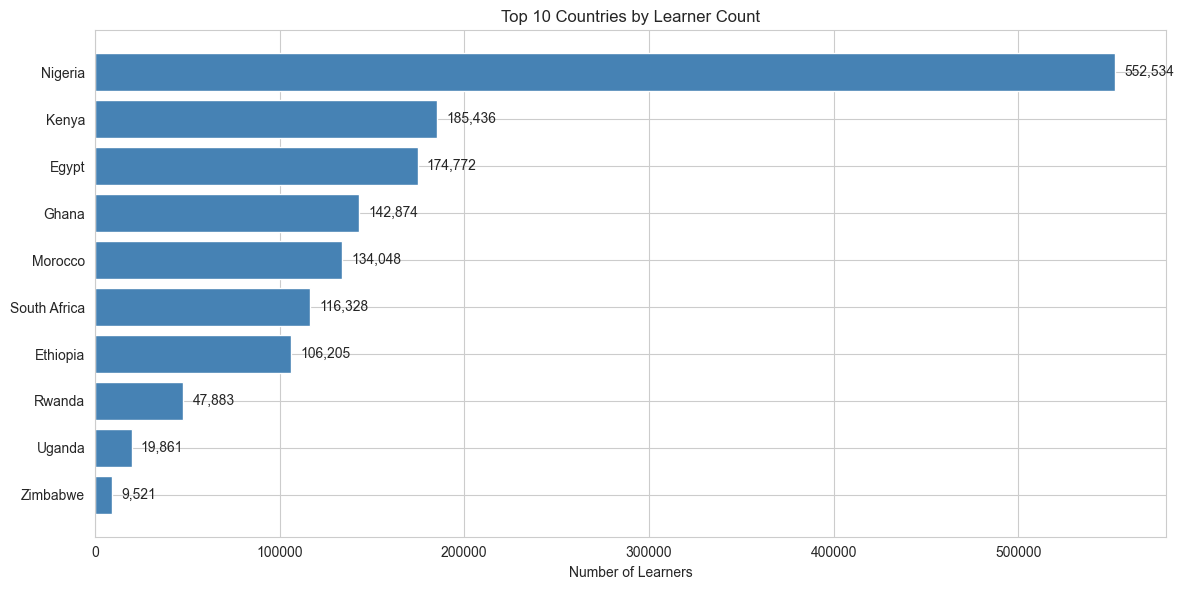

In [109]:
query = """
MATCH (l:Learner)
WHERE l.countryOfResidenceCode IS NOT NULL
WITH l.countryOfResidenceCode as countryCode, count(l) as learnerCount
MATCH (c:Country {code: countryCode})
RETURN c.name as country, c.code as code, learnerCount
ORDER BY learnerCount DESC
LIMIT 10
"""

top_countries = run_query(query)
print("Top 10 Countries by Learner Count:\n")
print(top_countries.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 6))
plt.barh(top_countries['country'], top_countries['learnerCount'], color='steelblue')
plt.xlabel('Number of Learners')
plt.title('Top 10 Countries by Learner Count')
plt.gca().invert_yaxis()
for i, v in enumerate(top_countries['learnerCount']):
    plt.text(v + 5000, i, f'{v:,}', va='center')
plt.tight_layout()
plt.show()

### 2.2 User Example: How many AiCE grads from Botswana?

This demonstrates program-specific + geographic filtering.

In [110]:
query = """
MATCH (l:Learner)-[e:ENROLLED_IN]->(p:Program)
WHERE l.countryOfResidenceCode = 'BW'
  AND p.name CONTAINS 'AiCE'
  AND e.enrollmentStatus IN ['Graduated', 'Completed']
RETURN count(DISTINCT l) as aiceGradsFromBotswana
"""

result = run_query(query)
count = result['aiceGradsFromBotswana'].iloc[0]
print(f"\n🎓 AiCE Graduates from Botswana: {count:,}")


🎓 AiCE Graduates from Botswana: 52


### 2.3 Gender Distribution by Top Countries


Gender Distribution by Top 5 Countries:

country                  gender  count
  Egypt                    male  93330
  Egypt                  female  59959
  Egypt other/prefer not to say  20917
  Ghana                    male  81040
  Ghana                  female  48184
  Ghana other/prefer not to say  13377
  Kenya                  female  80349
  Kenya                    male  72371
  Kenya other/prefer not to say  32174
Morocco                    male  68262
Morocco                  female  47093
Morocco other/prefer not to say  18433
Nigeria                  female 227988
Nigeria                    male 182251
Nigeria other/prefer not to say  82213


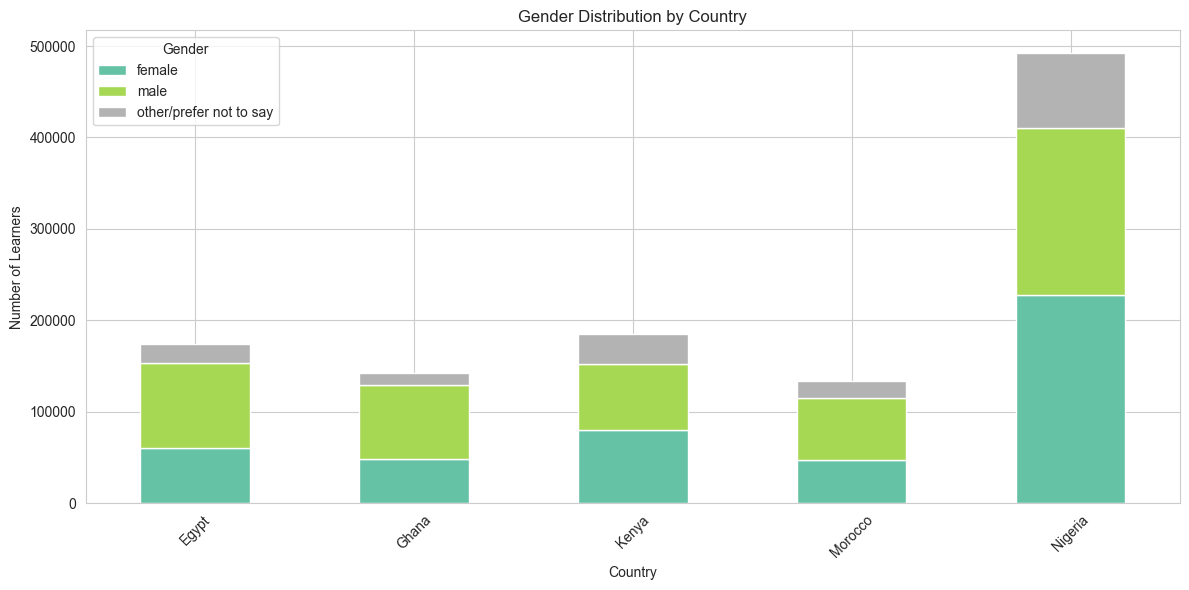

In [111]:
query = """
MATCH (l:Learner)
WHERE l.countryOfResidenceCode IN ['NG', 'KE', 'EG', 'GH', 'MA']
  AND l.gender IS NOT NULL
WITH l.countryOfResidenceCode as countryCode, l.gender as gender, count(l) as count
MATCH (c:Country {code: countryCode})
RETURN c.name as country, gender, count
ORDER BY country, count DESC
"""

gender_dist = run_query(query)
print("\nGender Distribution by Top 5 Countries:\n")
print(gender_dist.to_string(index=False))

# Pivot and visualize
gender_pivot = gender_dist.pivot(index='country', columns='gender', values='count').fillna(0)
gender_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title('Gender Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Number of Learners')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.4 Top 10 Cities by Learner Concentration

In [112]:
query = """
MATCH (l:Learner)
WHERE l.cityOfResidenceId IS NOT NULL
WITH l.cityOfResidenceId as cityId, count(l) as learnerCount
MATCH (city:City {id: cityId})
RETURN city.name as city, city.countryCode as country, learnerCount
ORDER BY learnerCount DESC
LIMIT 10
"""

top_cities = run_query(query)
print("\nTop 10 Cities by Learner Concentration:\n")
print(top_cities.to_string(index=False))


Top 10 Cities by Learner Concentration:

       city country  learnerCount
      lagos      NG        165767
      abuja      NG        164507
    nairobi      KE        140820
      Cairo      EG        132960
      Accra      GH        103472
addis ababa      ET         98275
      Rabat      MA         65902
     kigali      RW         44396
  Cape Town      ZA         40792
 casablanca      MA         30964


## 3. Program Enrollment & Performance Analysis

Deep dive into program enrollments, completion rates, and performance metrics.

### 3.1 Program Enrollment Distribution


Top 15 Programs by Enrollment:

                        program          cohort  enrollments
ALX AiCE - AI Career Essentials         AiCE-C3       143388
ALX AiCE - AI Career Essentials         AiCE-C4       101568
ALX AiCE - AI Career Essentials         AiCE-C2        90881
              Virtual Assistant           VA-C6        83561
           Software Engineering          SE-C13        73765
           Software Engineering          SE-C12        71657
              Virtual Assistant           VA-C5        50682
           Software Engineering           SE-C9        46473
              Virtual Assistant           VA-C4        40077
                ALX Foundations FOUNDATIONS-C10        38716
           Software Engineering          SE-C16        34139
           Software Engineering          SE-C11        33311
                ALX Foundations  FOUNDATIONS-C9        32713
           Software Engineering          SE-C17        29074
ALX AiCE - AI Career Essentials         AiCE-C7     

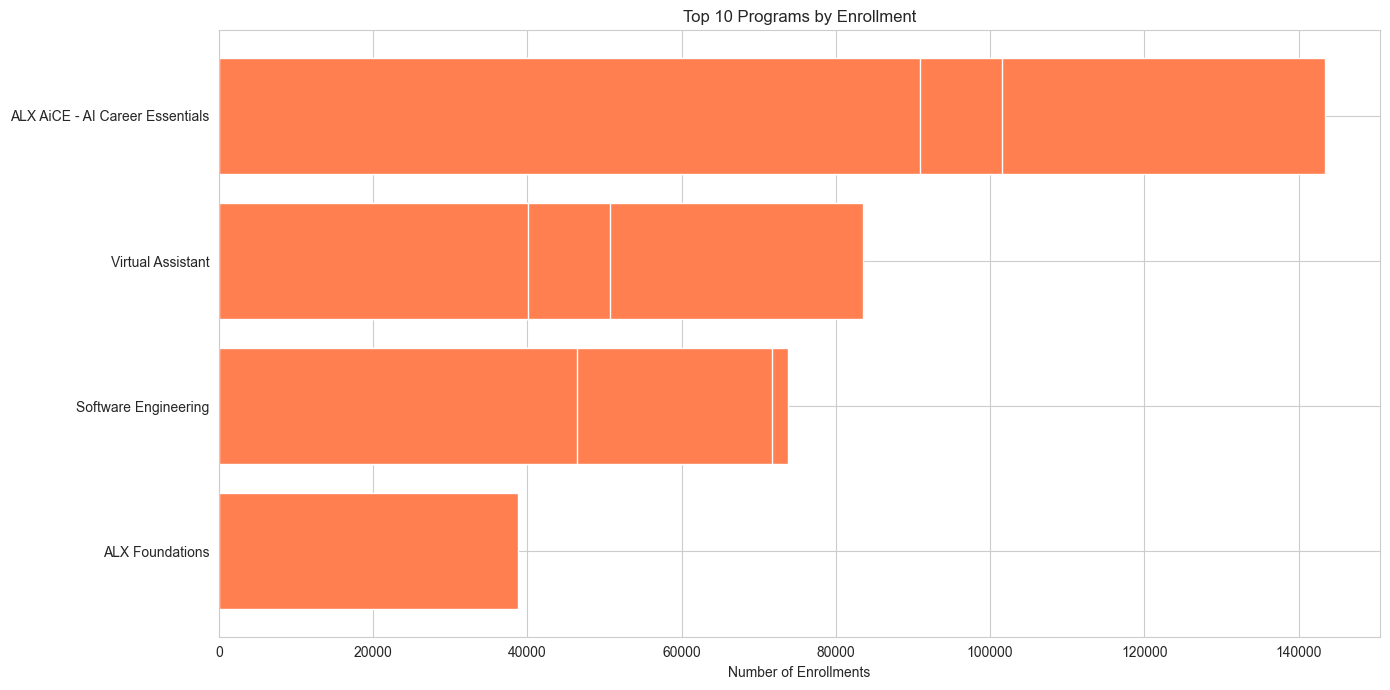

In [113]:
query = """
MATCH (p:Program)<-[:ENROLLED_IN]-(l:Learner)
RETURN p.name as program, p.cohortCode as cohort, count(l) as enrollments
ORDER BY enrollments DESC
LIMIT 15
"""

program_enrollment = run_query(query)
print("\nTop 15 Programs by Enrollment:\n")
print(program_enrollment.to_string(index=False))

# Visualization
plt.figure(figsize=(14, 7))
plt.barh(program_enrollment['program'].head(10), program_enrollment['enrollments'].head(10), color='coral')
plt.xlabel('Number of Enrollments')
plt.title('Top 10 Programs by Enrollment')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 3.2 Program Completion Rates

In [114]:
query = """
MATCH (p:Program)<-[e:ENROLLED_IN]-(l:Learner)
WITH p.name as program, 
     count(l) as totalEnrolled,
     sum(CASE WHEN e.enrollmentStatus IN ['Graduated', 'Completed'] THEN 1 ELSE 0 END) as completed,
     sum(CASE WHEN e.enrollmentStatus = 'Dropped Out' THEN 1 ELSE 0 END) as droppedOut
WHERE totalEnrolled > 1000
RETURN program,
       totalEnrolled,
       completed,
       droppedOut,
       round(100.0 * completed / totalEnrolled, 2) as completionRate,
       round(100.0 * droppedOut / totalEnrolled, 2) as dropoutRate
ORDER BY completionRate DESC
LIMIT 10
"""

completion_rates = run_query(query)
print("\nProgram Completion Rates (programs with >1000 enrollments):\n")
print(completion_rates.to_string(index=False))


Program Completion Rates (programs with >1000 enrollments):

                        program  totalEnrolled  completed  droppedOut  completionRate  dropoutRate
             ALX AI Starter Kit           6157       2580        3577           41.90        58.10
              Virtual Assistant         322162     115333      178359           35.80        55.36
              Financial Analyst          46018      13763       32255           29.91        70.09
                        Udacity          15382       4055       11327           26.36        73.64
                Founder Academy          19360       4971       14188           25.68        73.29
                ALX Foundations         194116      33789      121613           17.41        62.65
ALX AiCE - AI Career Essentials         447508      73756      373752           16.48        83.52
                 Data Scientist           2472        311        2161           12.58        87.42
           AI Career Essentials          21054 

### 3.3 Average LMS Performance by Program


Top 10 Programs by Average LMS Score:

                        program  learnerCount  avgLmsScore  avgCompletionRate
             ALX AI Starter Kit          6157        42.74               0.29
              Virtual Assistant        257878        40.06               0.36
                ALX Foundations        168525        19.10               0.13
ALX AiCE - AI Career Essentials        447508        16.73               0.16
           AI Career Essentials         21054        10.01               0.08
                   ALX Pathways         38025         3.36               0.01
    Freelancer Academy - 2-week          4366         1.19               0.00


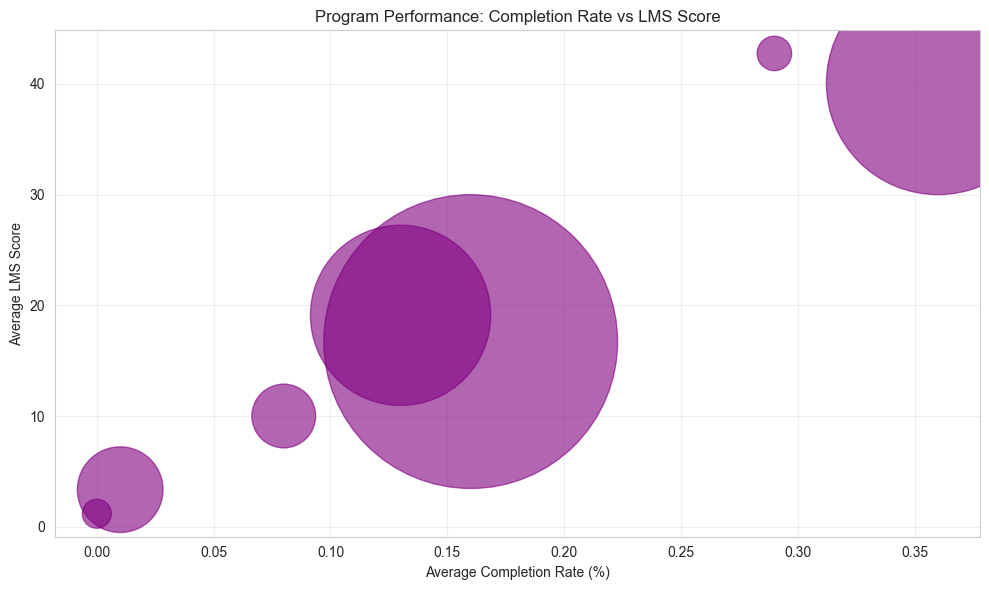

In [115]:
query = """
MATCH (p:Program)<-[e:ENROLLED_IN]-(l:Learner)
WHERE e.lmsOverallScore IS NOT NULL
WITH p.name as program, 
     count(l) as learnerCount,
     avg(e.lmsOverallScore) as avgScore,
     avg(e.completionRate) as avgCompletionRate
WHERE learnerCount > 500
RETURN program,
       learnerCount,
       round(avgScore, 2) as avgLmsScore,
       round(avgCompletionRate, 2) as avgCompletionRate
ORDER BY avgLmsScore DESC
LIMIT 10
"""

performance = run_query(query)
print("\nTop 10 Programs by Average LMS Score:\n")
print(performance.to_string(index=False))

# Scatter plot: Completion Rate vs LMS Score
plt.figure(figsize=(10, 6))
plt.scatter(performance['avgCompletionRate'], performance['avgLmsScore'],
            s=performance['learnerCount']/10, alpha=0.6, color='purple')
plt.xlabel('Average Completion Rate (%)')
plt.ylabel('Average LMS Score')
plt.title('Program Performance: Completion Rate vs LMS Score')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.4 Enrollment Status Distribution


Enrollment Status Distribution:

     status   count
Dropped Out 1235997
  Graduated  258919
   Enrolled   97251


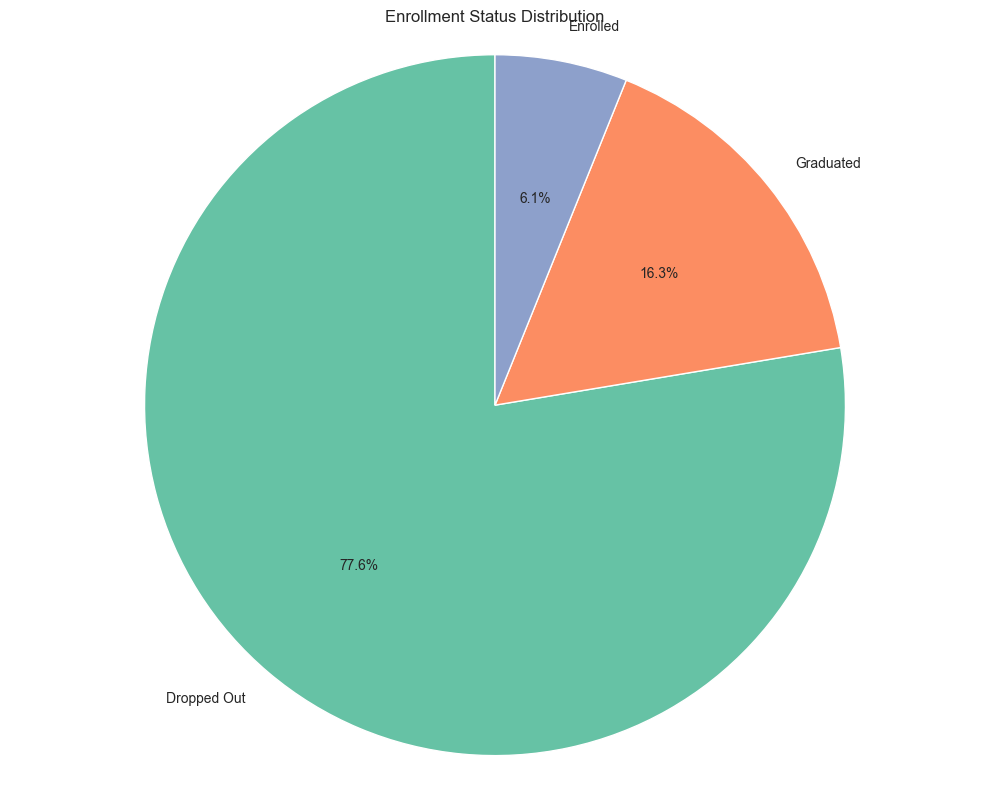

In [116]:
query = """
MATCH (:Learner)-[e:ENROLLED_IN]->(:Program)
WITH CASE 
    WHEN toLower(e.enrollmentStatus) = 'dropped out' THEN 'Dropped Out'
    WHEN toLower(e.enrollmentStatus) = 'enrolled' THEN 'Enrolled'
    WHEN toLower(e.enrollmentStatus) = 'graduated' THEN 'Graduated'
    WHEN toLower(e.enrollmentStatus) = 'active' THEN 'Active'
    ELSE e.enrollmentStatus
END as status
RETURN status, count(*) as count
ORDER BY count DESC
"""

enrollment_status = run_query(query)
print("\nEnrollment Status Distribution:\n")
print(enrollment_status.to_string(index=False))

# Pie chart
plt.figure(figsize=(10, 8))
plt.pie(enrollment_status['count'], labels=enrollment_status['status'],
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
plt.title('Enrollment Status Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()

## 4. Skills Ecosystem Analysis

Understanding the skills landscape across learners.

### 4.1 Top 20 Most Common Skills


Top 20 Most Common Skills:

                skill   category  learnerCount
    Process & tooling      Other        507786
             Sysadmin      Other        505704
        Deep Learning      Other        505323
          Mindmapping      Other        503606
          AI Literacy  Technical        446377
            Marketing   Business        435416
           Soft-skill      Other        378867
        Relationships      Other        368855
Low Level Programming  Technical        306020
             Back-end      Other         58058
            Front-end      Other         54167
             Security      Other         51155
              Network      Other         50788
     Entrepreneurship      Other         19081
             Webstack  Technical         10537
      Problem solving Soft Skill          7071
           Data entry  Technical          6995
             Teamwork Soft Skill          6822
     Email management  Technical          6314
             Research      Othe

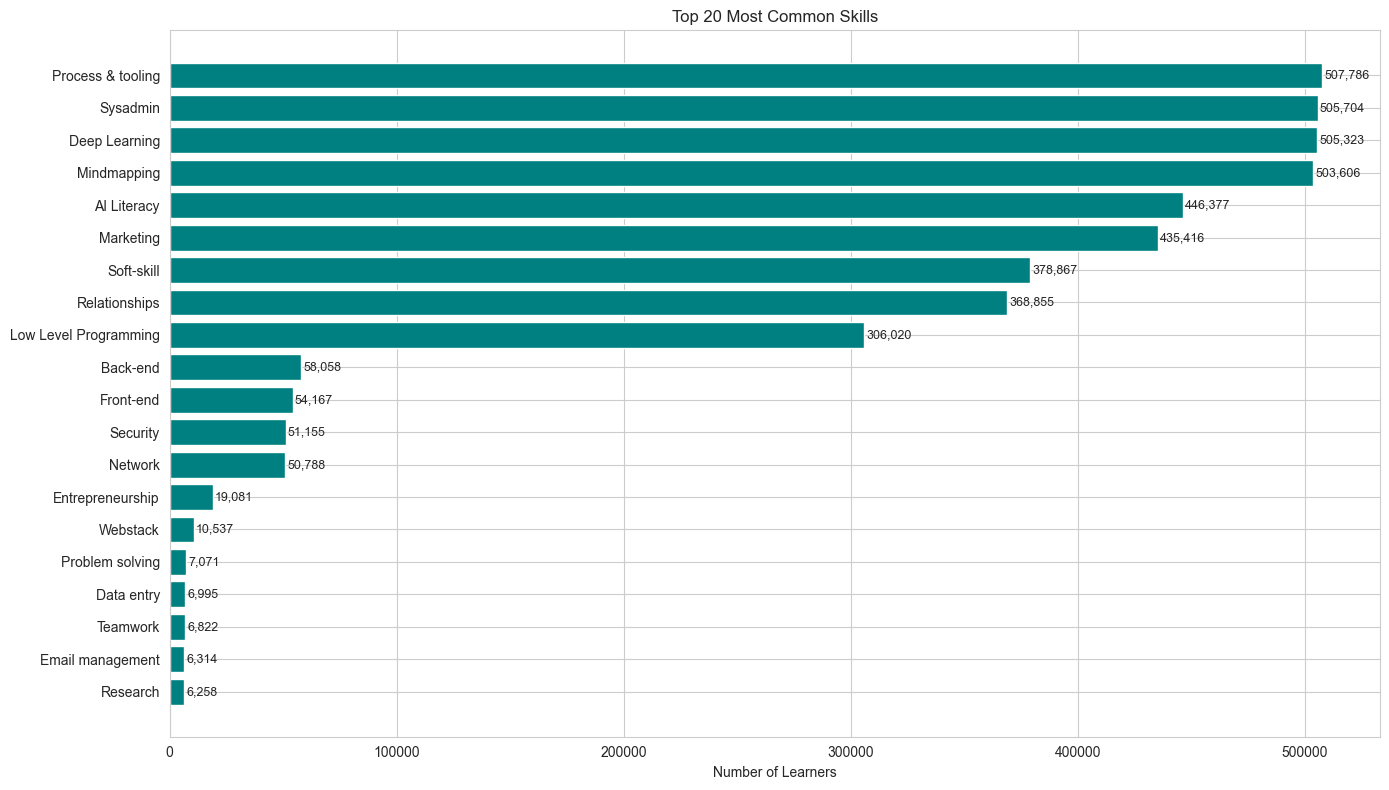

In [117]:
query = """
MATCH (s:Skill)<-[:HAS_SKILL]-(l:Learner)
RETURN s.name as skill, s.category as category, count(l) as learnerCount
ORDER BY learnerCount DESC
LIMIT 20
"""

top_skills = run_query(query)
print("\nTop 20 Most Common Skills:\n")
print(top_skills.to_string(index=False))

# Visualization
plt.figure(figsize=(14, 8))
plt.barh(top_skills['skill'], top_skills['learnerCount'], color='teal')
plt.xlabel('Number of Learners')
plt.title('Top 20 Most Common Skills')
plt.gca().invert_yaxis()
for i, v in enumerate(top_skills['learnerCount']):
    plt.text(v + 1000, i, f'{v:,}', va='center', fontsize=9)
plt.tight_layout()
plt.show()

### 4.2 Skills by Program Type

In [118]:
query = """
MATCH (l:Learner)-[:ENROLLED_IN]->(p:Program)
MATCH (l)-[:HAS_SKILL]->(s:Skill)
WHERE p.name CONTAINS 'AiCE'
RETURN s.name as skill, count(DISTINCT l) as learnerCount
ORDER BY learnerCount DESC
LIMIT 15
"""

aice_skills = run_query(query)
print("\nTop 15 Skills Among AiCE Learners:\n")
print(aice_skills.to_string(index=False))


Top 15 Skills Among AiCE Learners:

                skill  learnerCount
          AI Literacy        422204
           Soft-skill        127837
        Deep Learning          8085
    Process & tooling          8085
             Sysadmin          8079
          Mindmapping          8060
            Marketing          7206
        Relationships          6319
Low Level Programming          5679
     Entrepreneurship          4670
             Back-end          1017
             Teamwork           995
      Problem solving           912
            Front-end           899
             Security           876


### 4.3 Learners with Specific Skill Combinations

In [119]:
# Example: Find learners with both 'Python' and 'Data Analysis' skills
query = """
MATCH (l:Learner)-[:HAS_SKILL]->(s1:Skill)
WHERE s1.name IN ['Python', 'python', 'PYTHON']
MATCH (l)-[:HAS_SKILL]->(s2:Skill)
WHERE s2.name CONTAINS 'Data' OR s2.name CONTAINS 'data'
RETURN count(DISTINCT l) as learnersWithPythonAndData
"""

result = run_query(query)
count = result['learnersWithPythonAndData'].iloc[0] if not result.empty else 0
print(f"\n🐍 Learners with Python AND Data-related skills: {count:,}")


🐍 Learners with Python AND Data-related skills: 598


### 4.4 Average Skills per Learner by Program

In [120]:
query = """
MATCH (l:Learner)-[:ENROLLED_IN]->(p:Program)
OPTIONAL MATCH (l)-[:HAS_SKILL]->(s:Skill)
WITH p.name as program, l, count(s) as skillCount
WITH program, count(l) as learnerCount, avg(skillCount) as avgSkills
WHERE learnerCount > 1000
RETURN program, learnerCount, round(avgSkills, 2) as avgSkillsPerLearner
ORDER BY avgSkillsPerLearner DESC
LIMIT 10
"""

skills_per_learner = run_query(query)
print("\nAverage Skills per Learner by Program:\n")
print(skills_per_learner.to_string(index=False))


Average Skills per Learner by Program:

                             program  learnerCount  avgSkillsPerLearner
                Software Engineering        466246                 6.66
Introduction to Software Engineering          2297                 4.73
                     Founder Academy         19360                 2.27
                             Udacity         15382                 2.20
                   Financial Analyst         46018                 1.43
     ALX AiCE - AI Career Essentials        447508                 1.39
                      Data Scientist          2472                 1.24
                      Data Analytics          2750                 1.05
                   Virtual Assistant        322162                 1.04
                     ALX Foundations        194116                 0.77


## 5. Current State Distribution Analysis

Understanding the current learning and professional states of learners.

### 5.1 Current Learning State Distribution


Current Learning State Distribution:

      state  learnerCount
Dropped Out       1240482
   Graduate        259134
     Active         97551


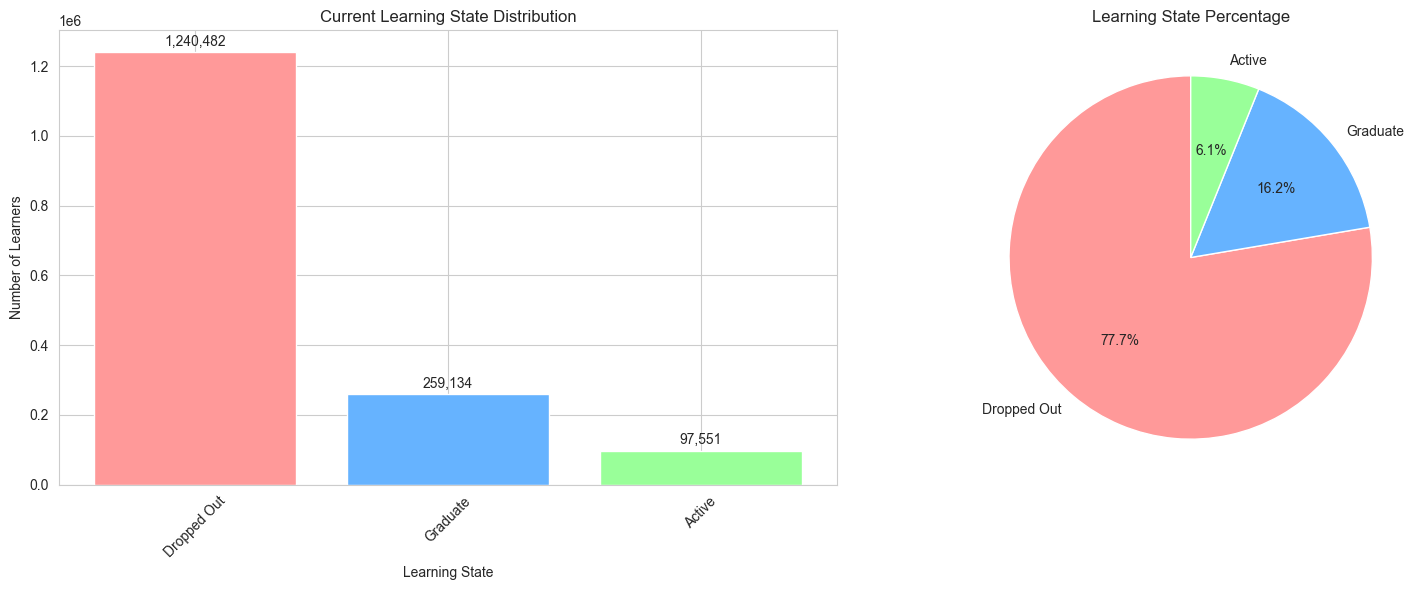

In [121]:
query = """
MATCH (l:Learner)
WHERE l.currentLearningState IS NOT NULL
RETURN l.currentLearningState as state, count(l) as learnerCount
ORDER BY learnerCount DESC
"""

learning_states = run_query(query)
print("\nCurrent Learning State Distribution:\n")
print(learning_states.to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
ax1.bar(learning_states['state'], learning_states['learnerCount'], color=['#ff9999', '#66b3ff', '#99ff99'])
ax1.set_xlabel('Learning State')
ax1.set_ylabel('Number of Learners')
ax1.set_title('Current Learning State Distribution')
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(learning_states['learnerCount']):
    ax1.text(i, v + 10000, f'{v:,}', ha='center', va='bottom')

# Pie chart
ax2.pie(learning_states['learnerCount'], labels=learning_states['state'],
        autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99'])
ax2.set_title('Learning State Percentage')

plt.tight_layout()
plt.show()

### 5.2 Current Professional Status Distribution


Current Professional Status Distribution:

       status  learnerCount
   Unemployed       1356194
Wage Employed        168455
     Multiple         64967
 Entrepreneur          7551


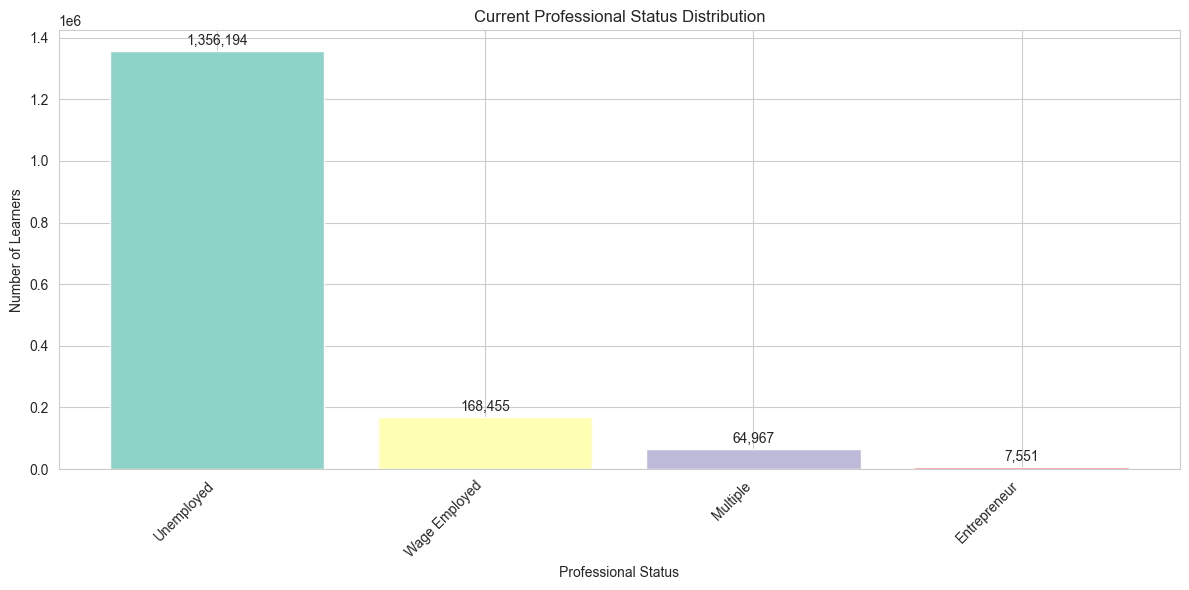

In [122]:
query = """
MATCH (l:Learner)
WHERE l.currentProfessionalStatus IS NOT NULL
RETURN l.currentProfessionalStatus as status, count(l) as learnerCount
ORDER BY learnerCount DESC
"""

prof_status = run_query(query)
print("\nCurrent Professional Status Distribution:\n")
print(prof_status.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 6))
colors = sns.color_palette('Set3', len(prof_status))
plt.bar(prof_status['status'], prof_status['learnerCount'], color=colors)
plt.xlabel('Professional Status')
plt.ylabel('Number of Learners')
plt.title('Current Professional Status Distribution')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(prof_status['learnerCount']):
    plt.text(i, v + 10000, f'{v:,}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

### 5.3 Learning State by Country (Top 5 Countries)


Learning State Distribution by Top 5 Countries:

country       state  count
  Egypt Dropped Out 144273
  Egypt    Graduate  23168
  Egypt      Active   7331
  Ghana Dropped Out  98395
  Ghana    Graduate  31035
  Ghana      Active  13444
  Kenya Dropped Out 129061
  Kenya    Graduate  38017
  Kenya      Active  18358
Morocco Dropped Out 111757
Morocco    Graduate  12253
Morocco      Active  10038
Nigeria Dropped Out 420122
Nigeria    Graduate 108462
Nigeria      Active  23950


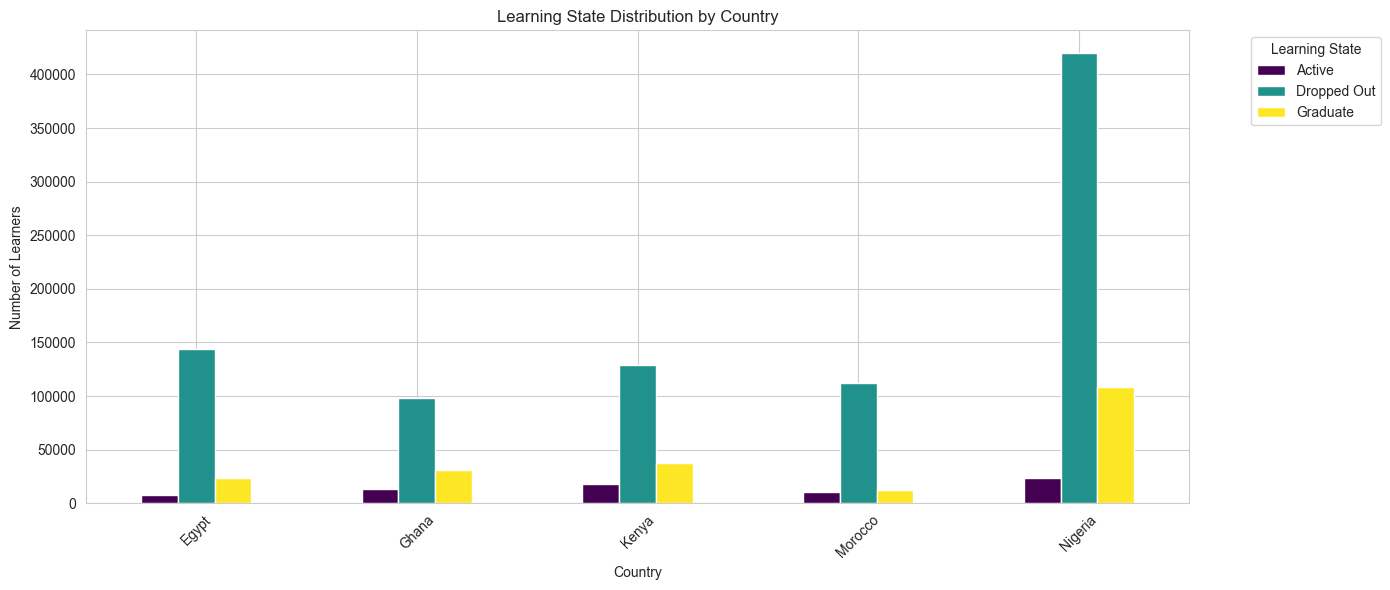

In [123]:
query = """
MATCH (l:Learner)
WHERE l.countryOfResidenceCode IN ['NG', 'KE', 'EG', 'GH', 'MA']
  AND l.currentLearningState IS NOT NULL
WITH l.countryOfResidenceCode as countryCode, 
     l.currentLearningState as state, 
     count(l) as count
MATCH (c:Country {code: countryCode})
RETURN c.name as country, state, count
ORDER BY country, count DESC
"""

state_by_country = run_query(query)
print("\nLearning State Distribution by Top 5 Countries:\n")
print(state_by_country.to_string(index=False))

# Pivot and visualize
pivot = state_by_country.pivot(index='country', columns='state', values='count').fillna(0)
pivot.plot(kind='bar', stacked=False, figsize=(14, 6), colormap='viridis')
plt.title('Learning State Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Number of Learners')
plt.legend(title='Learning State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Employment & Career Tracking

Analyzing employment outcomes and career progression.

### 6.1 Employment Rate by Current Professional Status

In [124]:
query = """
MATCH (l:Learner)
RETURN l.currentProfessionalStatus as status,
       count(l) as learnerCount,
       round(100.0 * count(l) / (SELECT count(*) FROM (MATCH (all:Learner) RETURN all)), 2) as percentage
ORDER BY learnerCount DESC
"""

# Simpler version
query = """
MATCH (l:Learner)
WHERE l.currentProfessionalStatus IS NOT NULL
WITH l.currentProfessionalStatus as status, count(l) as learnerCount
WITH status, learnerCount, sum(learnerCount) as total
RETURN status, learnerCount, round(100.0 * learnerCount / total, 2) as percentage
ORDER BY learnerCount DESC
"""

employment_rate = run_query(query)
print("\nEmployment Rate by Professional Status:\n")
print(employment_rate.to_string(index=False))


Employment Rate by Professional Status:

       status  learnerCount  percentage
   Unemployed       1356194       100.0
Wage Employed        168455       100.0
     Multiple         64967       100.0
 Entrepreneur          7551       100.0


### 6.2 Top 20 Employers

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: industry)} {position: line: 3, column: 29, offset: 73} for query: '\nMATCH (c:Company)<-[:WORKS_FOR]-(l:Learner)\nRETURN c.name as company, c.industry as industry, count(l) as employeeCount\nORDER BY employeeCount DESC\nLIMIT 20\n'



Top 20 Employers:

                                 company industry  employeeCount
                                     n/a     None          10866
                              alx_africa     None          10692
                               Freelance     None           9880
                                  Upwork     None           4389
                           Self-employed     None           3679
            National Youth Service Corps     None           2102
                           Self Employed     None           1555
Digital Egypt Pioneers Initiative - DEPI     None           1495
                               CIB Egypt     None           1474
                         Access Bank Plc     None           1456
               Freelance (Self employed)     None           1411
  Information Technology Institute (ITI)     None           1329
                                  Fiverr     None           1212
                               UBA Group     None           1005
     

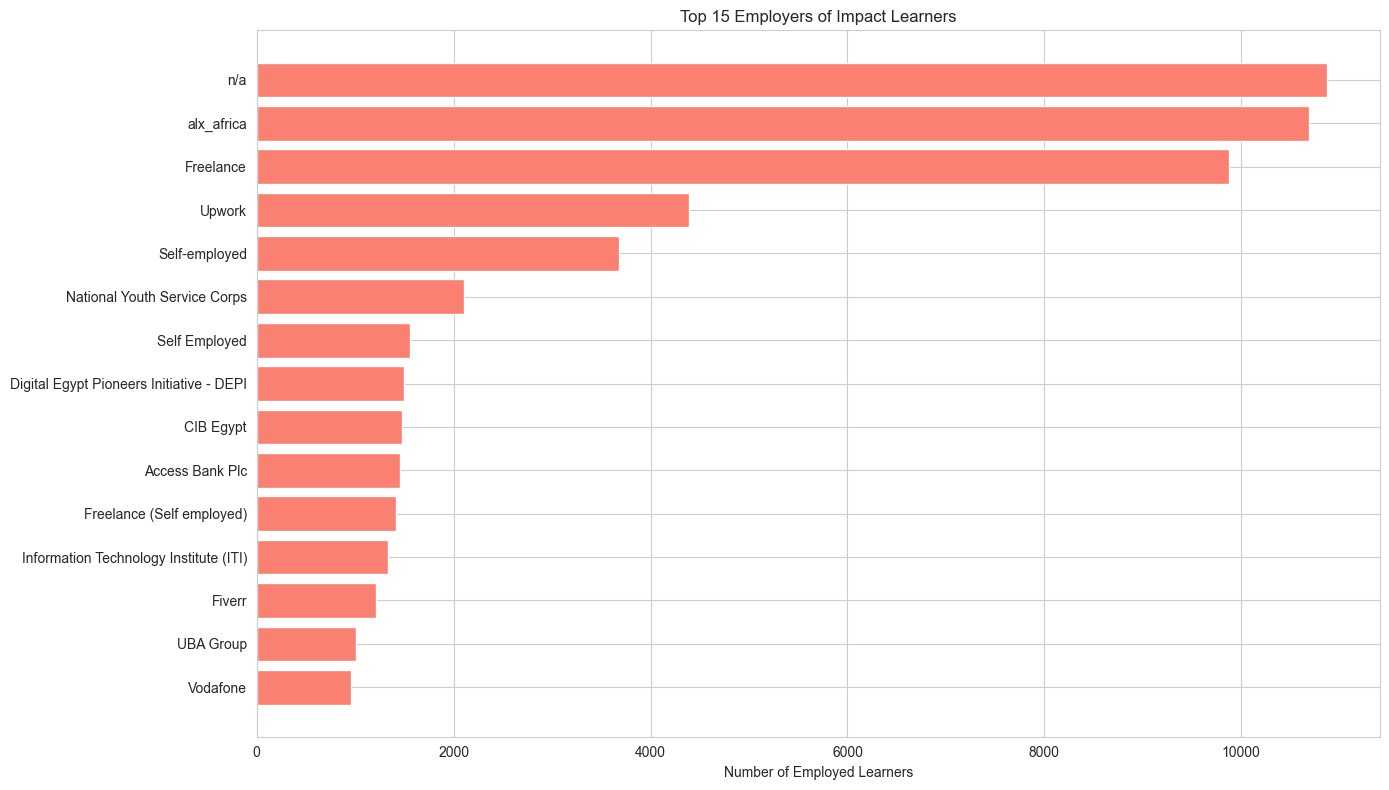

In [125]:
query = """
MATCH (c:Company)<-[:WORKS_FOR]-(l:Learner)
RETURN c.name as company, c.industry as industry, count(l) as employeeCount
ORDER BY employeeCount DESC
LIMIT 20
"""

top_employers = run_query(query)
print("\nTop 20 Employers:\n")
print(top_employers.to_string(index=False))

# Visualization
plt.figure(figsize=(14, 8))
plt.barh(top_employers['company'].head(15), top_employers['employeeCount'].head(15), color='salmon')
plt.xlabel('Number of Employed Learners')
plt.title('Top 15 Employers of Impact Learners')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 6.4 Employment by Program

In [126]:
query = """
MATCH (p:Program)<-[:ENROLLED_IN]-(l:Learner)
WITH p.name as program, count(l) as totalLearners
MATCH (p2:Program {name: program})<-[:ENROLLED_IN]-(l2:Learner)-[:WORKS_FOR]->(c:Company)
WITH program, totalLearners, count(DISTINCT l2) as employedLearners
WHERE totalLearners > 1000
RETURN program, 
       totalLearners, 
       employedLearners,
       round(100.0 * employedLearners / totalLearners, 2) as employmentRate
ORDER BY employmentRate DESC
LIMIT 10
"""

employment_by_program = run_query(query)
print("\nEmployment Rate by Program (programs with >1000 learners):\n")
print(employment_by_program.to_string(index=False))


Employment Rate by Program (programs with >1000 learners):

                             program  totalLearners  employedLearners  employmentRate
                   Financial Analyst          46018             14237           30.94
                     Founder Academy          19360              5950           30.73
                   Virtual Assistant         322162             98739           30.65
                      Data Scientist           2472               757           30.62
                      Data Analytics           2750               771           28.04
                             Udacity          15382              3889           25.28
     ALX AiCE - AI Career Essentials         447508             90023           20.12
Introduction to Software Engineering           2297               322           14.02
                     ALX Foundations         194116             26264           13.53
                  ALX AI Starter Kit           6157               815          

## 7. Complex Multi-Dimensional Queries

Combining multiple dimensions for deeper insights.

### 7.1 Graduate Employment Outcomes by Country


Graduate Employment Outcomes by Top 5 Countries:

country  totalGrads  employedGrads  employmentRate
  Egypt       23168          28650          123.66
Morocco       12253          12299          100.38
Nigeria      108462          94345           86.98
  Ghana       31035          23618           76.10
  Kenya       38017          28858           75.91


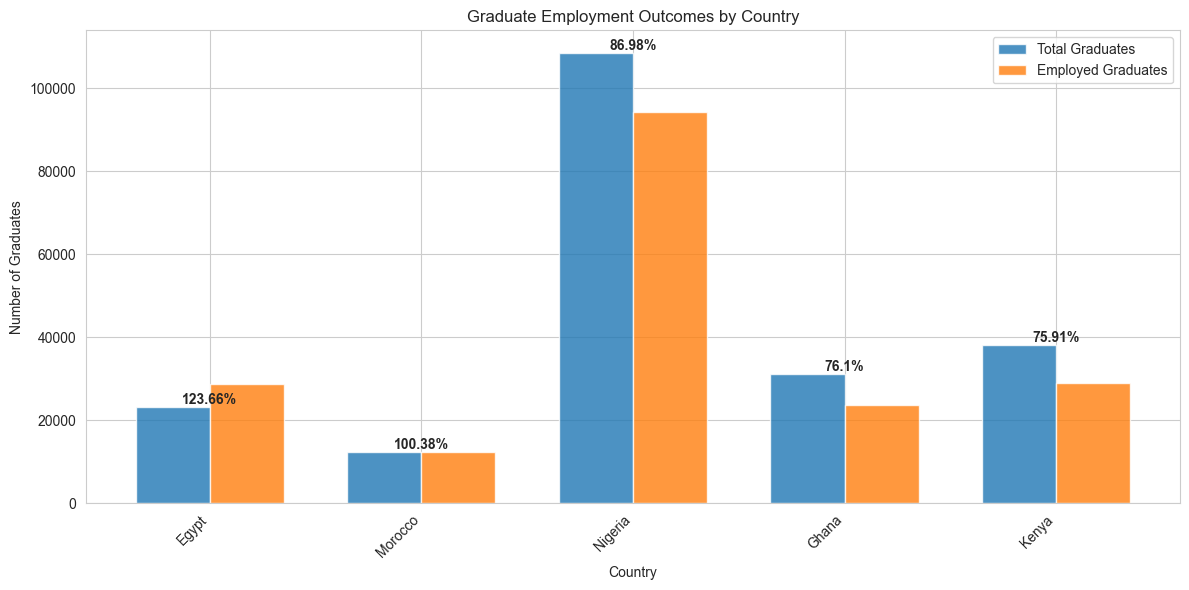

In [127]:
query = """
MATCH (l:Learner)-[e:ENROLLED_IN]->(:Program)
WHERE e.enrollmentStatus IN ['Graduated', 'Completed']
  AND l.countryOfResidenceCode IN ['NG', 'KE', 'EG', 'GH', 'MA']
WITH l.countryOfResidenceCode as countryCode, count(DISTINCT l) as totalGrads
MATCH (l2:Learner {countryOfResidenceCode: countryCode})-[:ENROLLED_IN]->(p:Program)
MATCH (l2)-[:WORKS_FOR]->(c:Company)
WHERE l2.currentProfessionalStatus IN ['Wage Employed', 'Entrepreneur', 'Multiple']
WITH countryCode, totalGrads, count(DISTINCT l2) as employedGrads
MATCH (country:Country {code: countryCode})
RETURN country.name as country,
       totalGrads,
       employedGrads,
       round(100.0 * employedGrads / totalGrads, 2) as employmentRate
ORDER BY employmentRate DESC
"""

grad_outcomes = run_query(query)
print("\nGraduate Employment Outcomes by Top 5 Countries:\n")
print(grad_outcomes.to_string(index=False))

# Visualization
if not grad_outcomes.empty:
    fig, ax = plt.subplots(figsize=(12, 6))
    x = range(len(grad_outcomes))
    width = 0.35

    ax.bar([i - width/2 for i in x], grad_outcomes['totalGrads'], width, label='Total Graduates', alpha=0.8)
    ax.bar([i + width/2 for i in x], grad_outcomes['employedGrads'], width, label='Employed Graduates', alpha=0.8)

    ax.set_xlabel('Country')
    ax.set_ylabel('Number of Graduates')
    ax.set_title('Graduate Employment Outcomes by Country')
    ax.set_xticks(x)
    ax.set_xticklabels(grad_outcomes['country'], rotation=45, ha='right')
    ax.legend()

    # Add employment rate as text
    for i, rate in enumerate(grad_outcomes['employmentRate']):
        ax.text(i, grad_outcomes['totalGrads'].iloc[i] + 50, f'{rate}%',
                ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

### 7.2 Skills Correlation with Employment

In [128]:
query = """
MATCH (s:Skill)<-[:HAS_SKILL]-(l:Learner)
WITH s.name as skill, count(DISTINCT l) as totalWithSkill
WHERE totalWithSkill > 1000
MATCH (s2:Skill {name: skill})<-[:HAS_SKILL]-(l2:Learner)-[:WORKS_FOR]->(:Company)
WITH skill, totalWithSkill, count(DISTINCT l2) as employedWithSkill
RETURN skill,
       totalWithSkill,
       employedWithSkill,
       round(100.0 * employedWithSkill / totalWithSkill, 2) as employmentRate
ORDER BY employmentRate DESC
LIMIT 15
"""

skills_employment = run_query(query)
print("\nTop 15 Skills by Employment Rate (skills with >1000 learners):\n")
print(skills_employment.to_string(index=False))


Top 15 Skills by Employment Rate (skills with >1000 learners):

                  skill  totalWithSkill  employedWithSkill  employmentRate
                  Sales            1083               1045           96.49
     Project management            3511               3365           95.84
       Customer support            5800               5557           95.81
    Presentation making            2881               2747           95.35
Social media management            2636               2513           95.33
             Data entry            6995               6657           95.17
               Research            6258               5939           94.90
           Organisation            4431               4199           94.76
       Email management            6314               5981           94.73
     Dashboard creation            1009                952           94.35
             Scheduling            4343               4096           94.31
     Data visualization            

### 7.3 High-Impact Learners (Graduates + Employed + Entrepreneurs)

In [129]:
query = """
MATCH (l:Learner)-[e:ENROLLED_IN]->(:Program)
WHERE e.enrollmentStatus IN ['Graduated', 'Completed']
  AND l.currentProfessionalStatus IN ['Entrepreneur', 'Multiple']
MATCH (l)-[:WORKS_FOR]->(c:Company)
RETURN count(DISTINCT l) as highImpactLearners
"""

result = run_query(query)
count = result['highImpactLearners'].iloc[0] if not result.empty else 0
print(f"\n🌟 High-Impact Learners (Graduates who are Entrepreneurs/Multiple ventures): {count:,}")


🌟 High-Impact Learners (Graduates who are Entrepreneurs/Multiple ventures): 41,314


## 8. Temporal Analysis Concepts

### Current Implementation vs Future Capabilities

**Current State:**
- Learner nodes have `currentLearningState` and `currentProfessionalStatus` properties
- ENROLLED_IN relationships have `startDate`, `endDate`, and `graduationDate`
- WORKS_FOR relationships have `startDate` and `isCurrent` flag

**Future Temporal Capabilities (via HAS_LEARNING_STATE and HAS_PROFESSIONAL_STATUS):**
When fully implemented, the graph will support:
1. **State Transition Tracking**: Track when learners move between states
2. **Time-to-Outcome Analysis**: Measure time from Active → Graduate
3. **Career Progression Timelines**: Unemployed → Employed → Entrepreneur transitions
4. **Temporal Queries**: "Show learners who were Active in Q1 2024 and are now Graduates"

Let's demonstrate what we can do with current temporal data:

In [130]:
# Query: Rare but valuable skills
query = """
MATCH (s:Skill)<-[:HAS_SKILL]-(l:Learner)
WITH s.name as skill, count(DISTINCT l) as totalWithSkill
WHERE totalWithSkill >= 50 AND totalWithSkill <= 500  // Rare skills (50-500 learners)

MATCH (s2:Skill {name: skill})<-[:HAS_SKILL]-(employed:Learner)-[:WORKS_FOR]->(:Company)
WITH skill, totalWithSkill, count(DISTINCT employed) as employedWithSkill
WITH skill, totalWithSkill, employedWithSkill,
     round(100.0 * employedWithSkill / totalWithSkill, 2) as employmentRate
WHERE employmentRate >= 80.0  // High employment rate
RETURN skill, totalWithSkill, employedWithSkill, employmentRate
ORDER BY employmentRate DESC, totalWithSkill DESC
LIMIT 15
"""

rare_valuable = run_query(query)
print("💎 Rare Skills Premium: Niche Skills with High Employment Value\n")
print("(Rare: 50-500 learners, High value: 80%+ employment rate)\n")
print(rare_valuable.to_string(index=False))

print("\n💡 Insight: These rare skills create disproportionate employment opportunities!")
print("    Recommendation: Focus curriculum development on these high-value niches.")

💎 Rare Skills Premium: Niche Skills with High Employment Value

(Rare: 50-500 learners, High value: 80%+ employment rate)

               skill  totalWithSkill  employedWithSkill  employmentRate
    Customer Service              51                 50           98.04
               Flask              66                 64           96.97
    Sales Operations              57                 55           96.49
              Django              72                 69           95.83
            Power BI              90                 86           95.56
     Microsoft Excel              56                 53           94.64
    Microsoft Office              65                 61           93.85
      Risk Modelling             482                450           93.36
        Transcribing              59                 55           93.22
            Airlines              56                 52           92.86
   virtual assistant             131                121           92.37
Attention to 

### 7.5.9 Rare Skills Premium: Uncommon Skills with High Employment Value

**Question**: Are there rare skills that, despite being uncommon, strongly correlate with employment?

This finds "hidden gems" - niche skills that create outsized employment opportunities.

In [131]:
# Query: Industry distribution by program
query = """
MATCH (p:Program)<-[:ENROLLED_IN]-(l:Learner)-[:WORKS_FOR]->(c:Company)
WHERE c.industry IS NOT NULL
WITH p.name as program, c.industry as industry, count(DISTINCT l) as learnerCount
WITH program, industry, learnerCount,
     sum(learnerCount) OVER (PARTITION BY program) as programTotal
WHERE programTotal > 500  // Programs with 500+ employed learners
WITH program, industry, learnerCount, programTotal,
     round(100.0 * learnerCount / programTotal, 2) as industryShare
WHERE industryShare >= 5.0  // Industries with 5%+ share
RETURN program, industry, learnerCount, industryShare
ORDER BY program, industryShare DESC
"""

industry_paths = run_query(query)
print("🏭 Industry Ecosystem: Program → Industry Career Pathways\n")
print("(Programs with 500+ employed learners, industries with 5%+ share)\n")

if not industry_paths.empty:
    # Group by program to show top industries per program
    for program_name in industry_paths['program'].unique()[:5]:
        program_data = industry_paths[industry_paths['program'] == program_name]
        print(f"\n{program_name}:")
        for _, row in program_data.iterrows():
            print(f"  • {row['industry']}: {row['learnerCount']:,} learners ({row['industryShare']}%)")

print("\n💡 Insight: Clear industry specialization patterns emerge for each program!")

CypherSyntaxError: {code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input 'OVER': expected
  "!="
  "%"
  "*"
  "+"
  ","
  "-"
  "/"
  "::"
  "<"
  "<="
  "<>"
  "="
  "=~"
  ">"
  ">="
  "AND"
  "AS"
  "CALL"
  "CONTAINS"
  "CREATE"
  "DELETE"
  "DETACH"
  "ENDS"
  "FOREACH"
  "IN"
  "IS"
  "LIMIT"
  "LOAD"
  "MATCH"
  "MERGE"
  "NODETACH"
  "OPTIONAL"
  "OR"
  "ORDER"
  "REMOVE"
  "RETURN"
  "SET"
  "SKIP"
  "STARTS"
  "UNION"
  "UNWIND"
  "USE"
  "WHERE"
  "WITH"
  "XOR"
  "^"
  <EOF> (line 6, column 24 (offset: 245))
"     sum(learnerCount) OVER (PARTITION BY program) as programTotal"
                        ^}

### 7.5.8 Industry Ecosystem Mapping: Program → Industry Pathways

**Question**: Which programs lead to which industries? What are the career pathway patterns?

This reveals how different programs connect to different industry ecosystems.

In [ ]:
# Query: Skills gap - comparing employed vs unemployed graduates
query = """
// Skills of employed graduates
MATCH (employed:Learner)-[e1:ENROLLED_IN]->(:Program)
WHERE e1.enrollmentStatus IN ['Graduated', 'Completed']
  AND employed.currentProfessionalStatus IN ['Wage Employed', 'Entrepreneur', 'Multiple']
MATCH (employed)-[:HAS_SKILL]->(s:Skill)
WITH s.name as skill, count(DISTINCT employed) as employedWithSkill

// Skills of unemployed graduates
MATCH (unemployed:Learner)-[e2:ENROLLED_IN]->(:Program)
WHERE e2.enrollmentStatus IN ['Graduated', 'Completed']
  AND unemployed.currentProfessionalStatus = 'Unemployed'
MATCH (unemployed)-[:HAS_SKILL]->(s2:Skill {name: skill})
WITH skill, employedWithSkill, count(DISTINCT unemployed) as unemployedWithSkill

// Calculate employment rate by skill
WHERE employedWithSkill + unemployedWithSkill > 100  // Minimum sample size
WITH skill, 
     employedWithSkill, 
     unemployedWithSkill,
     round(100.0 * employedWithSkill / (employedWithSkill + unemployedWithSkill), 2) as employmentRate
RETURN skill, 
       (employedWithSkill + unemployedWithSkill) as totalGradsWithSkill,
       employedWithSkill,
       unemployedWithSkill,
       employmentRate
ORDER BY employmentRate DESC
LIMIT 20
"""

skills_gap = run_query(query)
print("💼 Skills Gap Analysis: Employment Rate by Skill\n")
print("(For graduates only, skills with 100+ graduates)\n")
print(skills_gap.to_string(index=False))

print("\n💡 Insight: Top skills correlate strongly with employment success!")

### 7.5.7 Skills Gap Analysis: Employed vs Unemployed Graduates

**Question**: What skills do employed graduates have that unemployed graduates lack?

This reveals the "employability skills gap".

In [ ]:
# Query: Comparative analysis - Graduates vs Dropouts
query = """
// Employed Graduates
MATCH (grad:Learner)-[e1:ENROLLED_IN]->(:Program)
WHERE e1.enrollmentStatus IN ['Graduated', 'Completed']
MATCH (grad)-[:WORKS_FOR]->(:Company)
OPTIONAL MATCH (grad)-[:HAS_SKILL]->(s1:Skill)
WITH 'Employed Graduate' as category,
     count(DISTINCT grad) as learnerCount,
     avg(e1.lmsOverallScore) as avgLmsScore,
     avg(e1.completionRate) as avgCompletionRate,
     avg(size((grad)-[:HAS_SKILL]->(:Skill))) as avgSkillCount

UNION

// Dropouts
MATCH (drop:Learner)-[e2:ENROLLED_IN]->(:Program)
WHERE e2.enrollmentStatus = 'Dropped Out'
OPTIONAL MATCH (drop)-[:HAS_SKILL]->(s2:Skill)
WITH 'Dropout' as category,
     count(DISTINCT drop) as learnerCount,
     avg(e2.lmsOverallScore) as avgLmsScore,
     avg(e2.completionRate) as avgCompletionRate,
     avg(size((drop)-[:HAS_SKILL]->(:Skill))) as avgSkillCount

RETURN category, learnerCount, 
       round(avgLmsScore, 2) as avgLmsScore,
       round(avgCompletionRate, 2) as avgCompletionRate,
       round(avgSkillCount, 2) as avgSkillCount
ORDER BY category DESC
"""

comparison = run_query(query)
print("📊 Success Factor Analysis: Graduates vs Dropouts\n")
print(comparison.to_string(index=False))

if len(comparison) == 2:
    grad = comparison[comparison['category'] == 'Employed Graduate'].iloc[0]
    drop = comparison[comparison['category'] == 'Dropout'].iloc[0]
    print("\n🎯 Key Differences:")
    print(f"   Skill Count: Graduates have {grad['avgSkillCount'] / drop['avgSkillCount']:.1f}x more skills")
    print(f"   LMS Score: {grad['avgLmsScore'] - drop['avgLmsScore']:.1f} point difference")
    print(f"   Completion Rate: {grad['avgCompletionRate'] - drop['avgCompletionRate']:.1f}% difference")

### 7.5.6 Success Factor Analysis: Graduates vs Dropouts

**Question**: What differentiates graduates who get employed from those who drop out?

Compare skills, demographics, and program performance across outcomes.

In [ ]:
# Query: Cohorts that cluster at same companies
query = """
MATCH (l1:Learner)-[e1:ENROLLED_IN]->(p:Program)<-[e2:ENROLLED_IN]-(l2:Learner)
WHERE e1.cohortCode = e2.cohortCode  // Same cohort
  AND id(l1) < id(l2)  // Avoid duplicates
MATCH (l1)-[:WORKS_FOR]->(c:Company)<-[:WORKS_FOR]-(l2)
WITH p.name as program, 
     e1.cohortCode as cohort,
     c.name as company,
     count(*) as peerPairs
WHERE peerPairs >= 10  // At least 10 peer pairs
RETURN program, cohort, company, peerPairs
ORDER BY peerPairs DESC
LIMIT 20
"""

cohort_networks = run_query(query)
print("👥 Cohort Network Effects: Peers Working at Same Companies\n")
print("(Cohorts with 10+ peer pairs at same company)\n")
print(cohort_networks.to_string(index=False))

print("\n💡 Insight: Strong cohort effects suggest peer referrals and network benefits!")

### 7.5.5 Cohort Network Effects: Do Peers End Up at Same Companies?

**Question**: Are there "cohort effects" where learners from the same program cohort work at the same companies?

This demonstrates multi-hop graph traversal to find peer networks.

In [ ]:
# Query: Strong Program → Company hiring pipelines
query = """
MATCH (p:Program)<-[:ENROLLED_IN]-(l:Learner)-[:WORKS_FOR]->(c:Company)
WITH p.name as program, c.name as company, count(DISTINCT l) as hireCount
WHERE hireCount >= 50  // Significant hiring relationship
RETURN program, company, hireCount
ORDER BY hireCount DESC
LIMIT 25
"""

pipelines = run_query(query)
print("🏢 Company Hiring Ecosystems: Program → Company Pipelines\n")
print("(Showing pipelines with 50+ hires)\n")
print(pipelines.to_string(index=False))

print("\n💡 Insight: These represent strong talent pipelines and partnership opportunities!")

### 7.5.4 Company Hiring Ecosystems: Program → Company Pipelines

**Question**: Which companies hire from which programs? Are there preferred "pipelines"?

This reveals hiring patterns that would be hidden in traditional databases.

In [ ]:
# Query: Skill pairs that frequently occur together in employed learners
query = """
MATCH (l:Learner)-[:HAS_SKILL]->(s1:Skill),
      (l)-[:HAS_SKILL]->(s2:Skill),
      (l)-[:WORKS_FOR]->(:Company)
WHERE id(s1) < id(s2)  // Avoid duplicates and self-pairs
WITH s1.name as skill1, s2.name as skill2, count(DISTINCT l) as coOccurrence
WHERE coOccurrence > 100
RETURN skill1, skill2, coOccurrence
ORDER BY coOccurrence DESC
LIMIT 20
"""

skill_pairs = run_query(query)
print("🔗 Skill Synergy: Top Skill Pairs in Employed Learners\n")
print(skill_pairs.to_string(index=False))

print("\n💡 Insight: These skill combinations create the strongest employment profiles!")

### 7.5.3 Skill Synergy Networks: Which Skills Work Together?

**Question**: What skill combinations frequently appear together and lead to employment?

This demonstrates graph pattern matching to find skill co-occurrence networks.

In [ ]:
# Query: Geographic mobility analysis
query = """
MATCH (l:Learner)-[:WORKS_FOR]->(c:Company)
WHERE l.countryOfOriginCode IS NOT NULL 
  AND l.countryOfResidenceCode IS NOT NULL
  AND c.countryCode IS NOT NULL
WITH l.countryOfOriginCode as origin,
     l.countryOfResidenceCode as residence,
     c.countryCode as workCountry,
     count(*) as learnerCount
WHERE origin <> workCountry  // Moved countries for work
MATCH (c1:Country {code: origin}), (c2:Country {code: workCountry})
RETURN c1.name as originCountry,
       c2.name as workCountry,
       learnerCount,
       CASE 
         WHEN origin = residence THEN 'Relocated for work'
         WHEN residence = workCountry THEN 'Already relocated, now working'
         ELSE 'Complex mobility'
       END as mobilityType
ORDER BY learnerCount DESC
LIMIT 15
"""

mobility = run_query(query)
print("🌍 Geographic Mobility: Cross-Border Employment\n")
print(mobility.to_string(index=False))

if not mobility.empty:
    total_mobile = mobility['learnerCount'].sum()
    print(f"\n📊 Total learners working in different country from origin: {total_mobile:,}")
    print("💡 Insight: The HYBRID approach enables efficient geographic analysis!")

### 7.5.2 Geographic Mobility: Cross-Border Career Transitions

**Question**: Do learners move countries for work? What are the migration patterns?

This leverages the HYBRID approach: comparing `countryOfOriginCode` vs `countryOfResidenceCode` vs company location.

In [ ]:
# Query: Complete learning journey for a sample of successful learners
query = """
MATCH path = (l:Learner)-[:ENROLLED_IN]->(p:Program),
            (l)-[:HAS_SKILL]->(s:Skill),
            (l)-[:WORKS_FOR]->(c:Company)
WHERE l.currentLearningState = 'Graduate'
  AND l.currentProfessionalStatus IN ['Wage Employed', 'Entrepreneur']
WITH l.hashedEmail as learner,
     p.name as program,
     collect(DISTINCT s.name)[0..5] as topSkills,
     c.name as company,
     c.industry as industry
RETURN program, topSkills, industry, count(*) as learnerCount
ORDER BY learnerCount DESC
LIMIT 20
"""

journey_paths = run_query(query)
print("📍 Complete Learning Journeys: Program → Skills → Employment\n")
print("(Showing top 20 paths by frequency)\n")
print(journey_paths.to_string(index=False))

print("\n💡 Insight: This reveals the most common 'success paths' through the system")

### 7.5.1 Learning Journey Paths: From Enrollment to Employment

**Question**: What are the complete learning journeys of successfully employed graduates?

This query traverses the entire path: Learner → Program → Skills → Company

## 7.5 Advanced Graph Analytics: Revealing Hidden Patterns

This section demonstrates **Neo4j's true power** through advanced graph queries that would be extremely difficult or impossible in traditional relational databases. These queries leverage:
- **Multi-hop traversals**: Following paths across multiple relationship types
- **Pattern matching**: Finding complex patterns in the graph
- **Path analysis**: Understanding learner journeys
- **Network effects**: Discovering connections and communities

### 8.1 Program Duration Analysis

In [ ]:
query = """
MATCH (p:Program)<-[e:ENROLLED_IN]-(l:Learner)
WHERE e.startDate IS NOT NULL AND e.endDate IS NOT NULL
WITH p.name as program,
     duration.between(e.startDate, e.endDate).days as durationDays
WITH program, 
     avg(durationDays) as avgDuration,
     min(durationDays) as minDuration,
     max(durationDays) as maxDuration,
     count(*) as enrollmentCount
WHERE enrollmentCount > 100
RETURN program,
       enrollmentCount,
       round(avgDuration) as avgDurationDays,
       round(avgDuration / 30.0, 1) as avgDurationMonths,
       minDuration as minDays,
       maxDuration as maxDays
ORDER BY avgDurationDays DESC
LIMIT 10
"""

duration_analysis = run_query(query)
print("\nProgram Duration Analysis:\n")
print(duration_analysis.to_string(index=False))


Program Duration Analysis:

                             program  enrollmentCount  avgDurationDays  avgDurationMonths  minDays  maxDays
            Founder Academy - 4-week             3184             23.0                0.8        4       28
Introduction to Software Engineering             2297             22.0                0.7       15       24
     ALX AiCE - AI Career Essentials           447508             21.0                0.7        7       28
                AI Career Essentials            21054             20.0                0.7       19       22
           Front-End Web Development              184             19.0                0.6        5       28
                     Founder Academy            19360             19.0                0.6       11       30
                        ALX Pathways            38025             18.0                0.6       11       29
         Freelancer Academy - 2-week             4366             18.0                0.6        8       29

### 8.2 Time from Graduation to Employment

In [ ]:
query = """
MATCH (l:Learner)-[e:ENROLLED_IN]->(p:Program)
MATCH (l)-[w:WORKS_FOR]->(c:Company)
WHERE e.graduationDate IS NOT NULL 
  AND w.startDate IS NOT NULL
  AND w.startDate >= e.graduationDate
WITH duration.between(e.graduationDate, w.startDate).days as daysToEmployment
WHERE daysToEmployment >= 0 AND daysToEmployment < 730  // Within 2 years
RETURN 
  count(*) as totalTransitions,
  round(avg(daysToEmployment)) as avgDaysToEmployment,
  round(avg(daysToEmployment) / 30.0, 1) as avgMonthsToEmployment,
  min(daysToEmployment) as minDays,
  max(daysToEmployment) as maxDays,
  percentileCont(daysToEmployment, 0.5) as medianDays
"""

time_to_employment = run_query(query)
print("\n⏱️  Time from Graduation to Employment:\n")
print(time_to_employment.to_string(index=False))


⏱️  Time from Graduation to Employment:

 totalTransitions  avgDaysToEmployment  avgMonthsToEmployment  minDays  maxDays  medianDays
            49057                 15.0                    0.5        0       30          15


### 8.3 Employment Retention Analysis

In [ ]:
query = """
MATCH (l:Learner)-[w:WORKS_FOR]->(c:Company)
WHERE w.isCurrent IS NOT NULL
RETURN 
  w.isCurrent as currentlyEmployed,
  count(*) as employmentRecords,
  count(DISTINCT l) as uniqueLearners
ORDER BY currentlyEmployed DESC
"""

retention = run_query(query)
print("\n📊 Employment Retention:\n")
print(retention.to_string(index=False))

if not retention.empty and len(retention) > 1:
    current = retention[retention['currentlyEmployed'] == True]['uniqueLearners'].iloc[0]
    past = retention[retention['currentlyEmployed'] == False]['uniqueLearners'].iloc[0]
    retention_rate = round(100.0 * current / (current + past), 2)
    print(f"\nRetention Rate: {retention_rate}% of learners are still employed")


📊 Employment Retention:

 currentlyEmployed  employmentRecords  uniqueLearners
              True             303575          223076
             False             598115          214041

Retention Rate: 51.03% of learners are still employed


## 9. Summary & Key Insights

Let's summarize the key findings from our analysis:


⏱️  Time from Graduation to Employment by Program:

(Programs with at least 100 grad-to-employment transitions)

                        program  totalTransitions  avgDaysToEmployment  avgMonthsToEmployment  minDays  maxDays  medianDays
                ALX Foundations              5453                  7.0                    0.2        1       28         5.0
                Founder Academy               388                 10.0                    0.3        0       30         8.0
           Software Engineering              1549                 13.0                    0.4        0       28        17.0
                        Udacity              2520                 15.0                    0.5        0       30        16.0
              Virtual Assistant             18703                 16.0                    0.5        0       30        20.0
              Financial Analyst              7067                 16.0                    0.5        0       30        17.0
ALX AiCE - AI Care

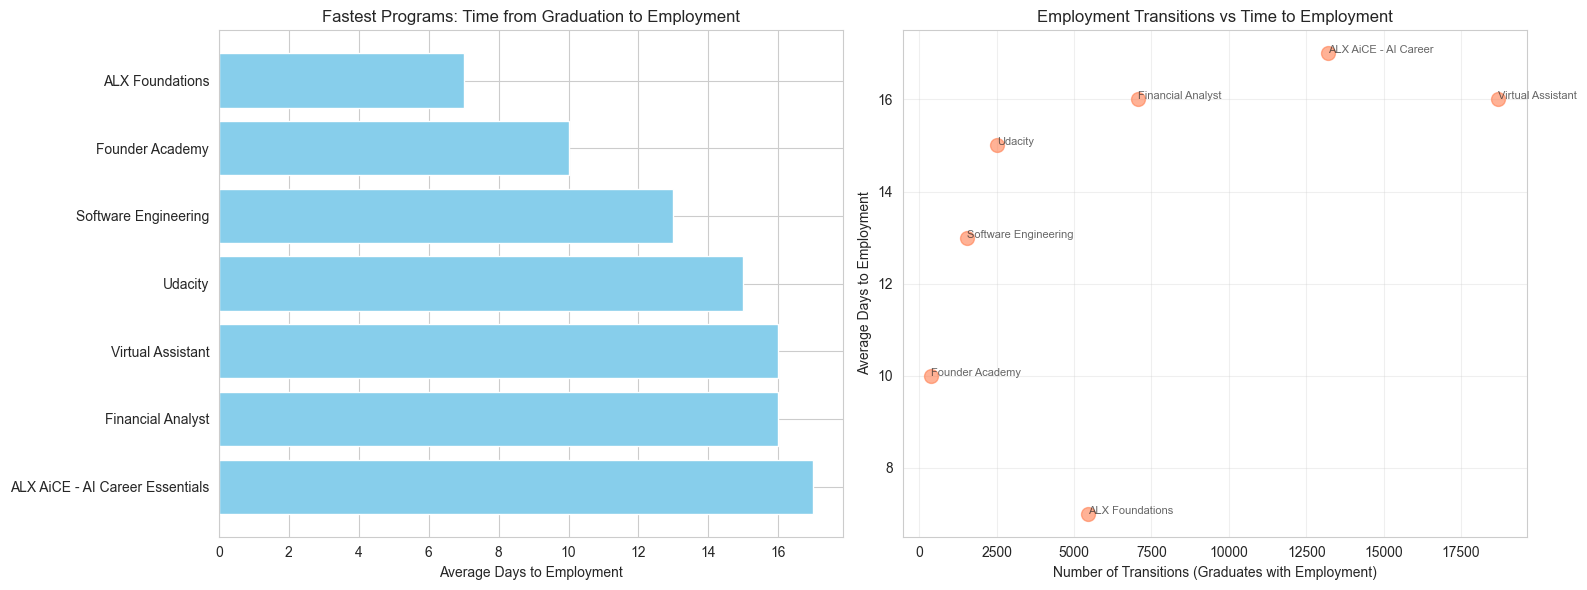


🚀 Fastest Program: ALX Foundations
   Average time to employment: 7.0 days (0.2 months)
   Median: 5.0 days
   Sample size: 5,453 graduates


In [ ]:
query = """
MATCH (l:Learner)-[e:ENROLLED_IN]->(p:Program)
MATCH (l)-[w:WORKS_FOR]->(c:Company)
WHERE e.graduationDate IS NOT NULL 
  AND w.startDate IS NOT NULL
  AND w.startDate >= e.graduationDate
WITH p.name as program,
     duration.between(e.graduationDate, w.startDate).days as daysToEmployment
WHERE daysToEmployment >= 0 AND daysToEmployment < 730  // Within 2 years
WITH program,
     count(*) as totalTransitions,
     round(avg(daysToEmployment)) as avgDaysToEmployment,
     round(avg(daysToEmployment) / 30.0, 1) as avgMonthsToEmployment,
     min(daysToEmployment) as minDays,
     max(daysToEmployment) as maxDays,
     round(percentileCont(daysToEmployment, 0.5)) as medianDays
WHERE totalTransitions >= 100  // Programs with at least 100 transitions
RETURN program, totalTransitions, avgDaysToEmployment, avgMonthsToEmployment,
       minDays, maxDays, medianDays
ORDER BY avgDaysToEmployment ASC
LIMIT 15
"""

time_to_employment = run_query(query)
print("\n⏱️  Time from Graduation to Employment by Program:\n")
print("(Programs with at least 100 grad-to-employment transitions)\n")
print(time_to_employment.to_string(index=False))

# Visualization
if not time_to_employment.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Bar chart: Average days to employment
    ax1.barh(time_to_employment['program'].head(10),
             time_to_employment['avgDaysToEmployment'].head(10),
             color='skyblue')
    ax1.set_xlabel('Average Days to Employment')
    ax1.set_title('Fastest Programs: Time from Graduation to Employment')
    ax1.invert_yaxis()

    # Scatter: Transitions vs Avg Days
    ax2.scatter(time_to_employment['totalTransitions'],
                time_to_employment['avgDaysToEmployment'],
                s=100, alpha=0.6, color='coral')
    ax2.set_xlabel('Number of Transitions (Graduates with Employment)')
    ax2.set_ylabel('Average Days to Employment')
    ax2.set_title('Employment Transitions vs Time to Employment')
    ax2.grid(True, alpha=0.3)

    # Annotate programs
    for idx, row in time_to_employment.head(10).iterrows():
        ax2.annotate(row['program'][:20],
                    (row['totalTransitions'], row['avgDaysToEmployment']),
                    fontsize=8, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Key insights
    fastest_program = time_to_employment.iloc[0]
    print(f"\n🚀 Fastest Program: {fastest_program['program']}")
    print(f"   Average time to employment: {fastest_program['avgDaysToEmployment']} days "
          f"({fastest_program['avgMonthsToEmployment']} months)")
    print(f"   Median: {fastest_program['medianDays']} days")
    print(f"   Sample size: {fastest_program['totalTransitions']:,} graduates")

## 10. Future Temporal Capabilities

### Example Query (When HAS_LEARNING_STATE is fully implemented):

```cypher
// Track state transitions over time
MATCH (l:Learner)-[r:HAS_LEARNING_STATE]->(s:LearningState)
WHERE s.state = 'Active' 
  AND s.endDate IS NOT NULL
MATCH (l)-[r2:HAS_LEARNING_STATE]->(s2:LearningState)
WHERE s2.startDate = s.endDate
  AND s2.state = 'Graduate'
WITH duration.between(s.startDate, s2.startDate).days as daysToGraduation
RETURN 
  avg(daysToGraduation) as avgDaysToGraduation,
  percentileCont(daysToGraduation, 0.5) as medianDaysToGraduation
```

This would enable:
- **State change analysis**: Who dropped out and when?
- **Re-engagement tracking**: Inactive → Active transitions
- **Career progression**: Unemployed → Freelancer → Entrepreneur paths
- **Time-series analysis**: State distributions by month/quarter
- **Predictive modeling**: Patterns that lead to successful outcomes

## Cleanup

In [ ]:
# Close Neo4j connection
driver.close()
print("✓ Neo4j connection closed")

✓ Neo4j connection closed
